*italicized text*# Deep learning for hyperspectral image processing: 2-D convolutional neural networks
This notebook demonstrates application of 2-Dimensional Convolutional Neural Network (2-D CNN) models to land use classification. Unlike Multi-Layer Perceptron [(MLP)](deep_learning_MLP.ipynb) models, where each pixel is considered as an input vector, the 2-D CNN models also utilize the spatial information of the neighboring pixels. A separate notebook is also available, describing the application of 3-Dimenaional Convolutional neural networks to landuse classification[(3-D CNN)](deep_learning_3D_CNN.ipynb).

## Module imports
Below is the list of libraries and modules that are required in this notebook. The 'keras' package provides the building blocks for model configuration and training. The 'img_util' contains a set of useful functions for pre-processing of raw data to create input and output data containers, compatible to the 'keras' package. In addition, it provides a set of functions for post-processing of results and visualization of prediction maps.
The 'sio' and 'os' module were used for working with external files. The plotting of data and generation of prediction maps were achieved using plotting functionalities of 'matplotlib'.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Walter/RADHESYAM_VADDI_2DCNN/')


import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt


In [ ]:
!pwd

/content


In [ ]:
# very IMP
cd /content/drive/MyDrive/2D3D_CNN

SyntaxError: invalid decimal literal (<ipython-input-3-e75024530d2a>, line 2)

# New Section

## Hyperspectral dataset
A set of publically-available hyperspectral imageray datasets can be downloaded form [this](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) website. The Indian Pine dataset was downloaded and used in this notebook. The dataset consists of 150$\times$150 pixels with 200 refelactance bands. The ground truth data for the dataset consists of 16 different classes. A summary of landuse types and their corresponding number of samples can be found in the following table:

| ID       | Class                        | Samples |
|----------|------------------------------|---------|
| 0        | Unlabeled                    | 10776   |
| 1        | Alfalfa                      | 46      |
| 2        | Corn-notill                  | 1428    |
| 3        | Corn-mintill                 | 830     |
| 4        | Corn                         | 237     |
| 5        | Grass-pasture                | 483     |
| 6        | Grass-trees                  | 730     |
| 7        | Grass-pasture-mowed          | 28      |
| 8        | Hay-windrowed                | 478     |
| 9        | Oats                         | 20      |
| 10       | Soybean-notill               | 972     |
| 11       | Soybean-mintill              | 2455    |
| 12       | Soybean-clean                | 593     |
| 13       | Wheat                        | 205     |
| 14       | Woods                        | 1265    |
| 15       | Buildings-Grass-Trees-Drives | 386     |
| 16       | Stone-Steel-Towers           | 93      |

The image data and class labels are available in two separate Matlab files with .mat extension. Therefore, the data were loaded into Python using the 'loadmat' function, available in the 'io' module of Scipy.

In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/Walter/RADHESYAM_VADDI_2DCNN/Datasets'
data_file= 'PaviaU'
gt_file = 'PaviaU_gt'
#original
data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('paviaU')
gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('paviaU_gt')
#partitioned based IP
#data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('combinedbands')
#gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('indian_pines_gt')
#partitioned based SA
#data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('combinedbands')
#gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('salinas_gt')
# KSC
# data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('KSC')
# gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('KSC_gt')
#data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('Botswana')
#gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('Botswana_gt')
# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(610, 340, 103) (610, 340)


## Training and test data
The 'data_split' function was used for splitting the data into training and test sets using 0.75 as the split ratio (75% of labeled pixels were used for training). This function ensures that all classes are represented in the training dataset (see function documentation for available split methods). In addition, it allows users to focus their analysis on certain classes and remove those pixels that are not labeled. For example, the unlabeled data are represented by 0 in the gourd truth data file. Therefore, 0 was included in 'rem_classes' list, indicating its removal from the dataset.

In [ ]:
train_fraction = 0.75
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 32077.
Number of test samples = 10697.


A portion of training data can optionally be set aside for validation.

In [ ]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [ ]:
# data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set = util.reduce_dim(img_data=data_set, n_components=10)
data_set.shape


(610, 340, 10)

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

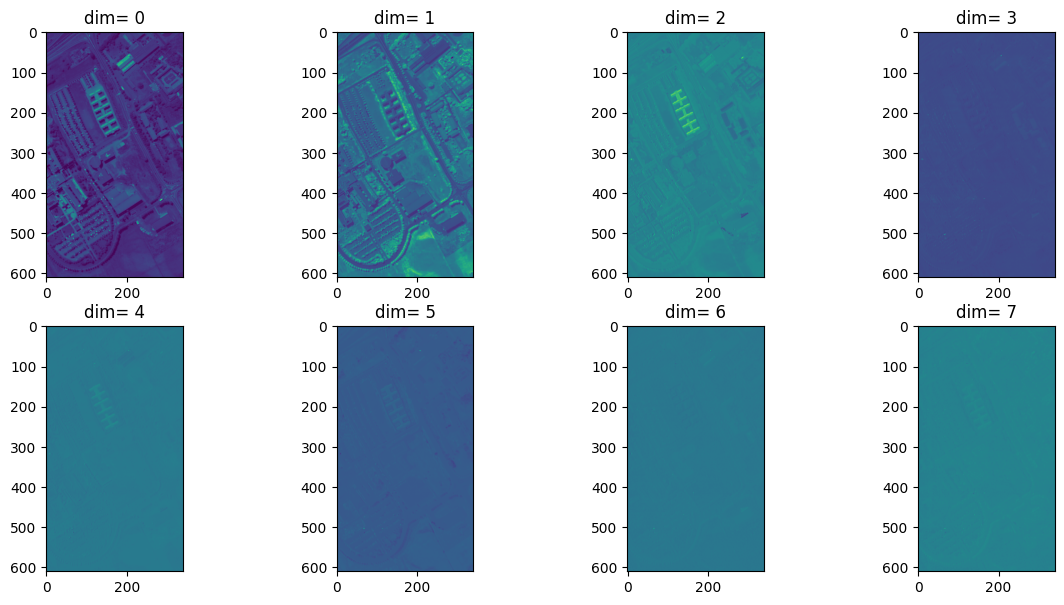

In [ ]:
fig, axes = plt.subplots(2,4,figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(data_set[:,:,numb])
    axe.set_title('dim='+' '+str(numb))
fig.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the 'standard' method which transforms the data to have zero mean and a standard deviation of 1 was used for rescaling data.

In [ ]:
data_set = util.rescale_data(data_set)

In [ ]:
data_set.shape

(610, 340, 10)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models.
In this notebook, a 2-D CNN model with a 'path_size' of 5 is used for classification.  

In [ ]:
patch_size=5
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols)
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels)

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)


val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

## Creating a 2-D CNN model
The network architecture consists of a 2-D convolutional layer as input layer. The input layer is followed by a maximum pooling layer with a pooling and stride size of 2. The third layer is a another 2-D convolutional layer, followed by a maximum pooling layer. The fifth layer flattens the outputs of the forth layer and pass them to a 'drop out' layer with a drop rate of 0.35. The 'drop out' layer is followed by three 'dense' layers with the last one as the output layer.

In [1]:
kernel_size = 3
pool_size = 2
lr = 1e-4
l2_parm = 1e-3
batch_size = 2**8#2**3
filters_1 = 2**6
filters_2 = 2**7
units_1 = 2**8
units_2 = 2**7
units_3 = 2**6
units_4 = 2**5
drop_rate = 0.35
num_catg = len(catg_labels)
input_shape = train_input_sub.shape[1:]
print(input_shape)
# Building a 2-D CNN model
cnn_model = models.Sequential()
# conv_2D__1 (Input layer)
cnn_model.add(layer=layers.Conv2D(filters=filters_1, kernel_size=kernel_size,
                                  strides=1, padding='same',
                                  kernel_regularizer=regularizers.l2(l2_parm),
                                  input_shape=input_shape))
# max_pool_1
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size, strides=pool_size,padding='valid'))
# conv_2_D_2
cnn_model.add(layer=layers.Conv2D(filters=filters_2, kernel_size=kernel_size,
                                  strides=1, padding='same',
                                  kernel_regularizer=regularizers.l2(l2_parm)))
# max_pool_2
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size, strides=pool_size,padding='valid'))



# flatten_1
cnn_model.add(layer=layers.Flatten())
# dropout_1
cnn_model.add(layer=layers.Dropout(drop_rate))

# dense_1
cnn_model.add(layer=layers.Dense(units=units_1, activation='relu'))
# dense_2
cnn_model.add(layer=layers.Dense(units=units_2, activation='relu'))
# dense_3
cnn_model.add(layer=layers.Dense(units=units_3, activation='relu'))

cnn_model.add(layer=layers.Dense(units=units_4, activation='relu'))
# dense_4 (output_layer)
cnn_model.add(layer=layers.Dense(units=9, activation='softmax'))

cnn_model.summary()

NameError: name 'catg_labels' is not defined

In [ ]:
!pip install adam

In [ ]:
from tensorflow.keras.optimizers import Adam

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors)

Epoch 1/20
953/953 [==============================] - 13s 12ms/step - loss: 0.2851 - categorical_accuracy: 0.9360 - val_loss: 0.1892 - val_categorical_accuracy: 0.9664
Epoch 2/20
953/953 [==============================] - 15s 16ms/step - loss: 0.1684 - categorical_accuracy: 0.9728 - val_loss: 0.1236 - val_categorical_accuracy: 0.9851
Epoch 3/20
953/953 [==============================] - 14s 14ms/step - loss: 0.1279 - categorical_accuracy: 0.9831 - val_loss: 0.1080 - val_categorical_accuracy: 0.9863
Epoch 4/20
953/953 [==============================] - 14s 15ms/step - loss: 0.1332 - categorical_accuracy: 0.9804 - val_loss: 0.1176 - val_categorical_accuracy: 0.9888
Epoch 5/20
953/953 [==============================] - 8s 9ms/step - loss: 0.1305 - categorical_accuracy: 0.9838 - val_loss: 0.1170 - val_categorical_accuracy: 0.9876
Epoch 6/20
953/953 [==============================] - 9s 9ms/step - loss: 0.1031 - categorical_accuracy: 0.9870 - val_loss: 0.0873 - val_categorical_accuracy: 0.9

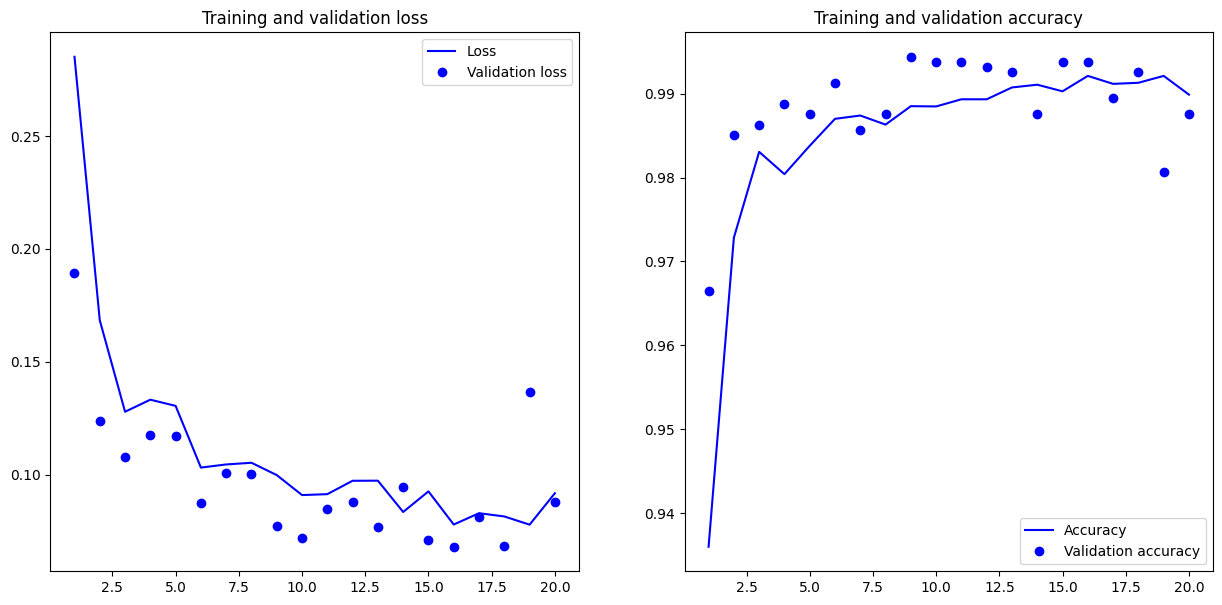

In [ ]:
lr = 1e-4
batch_size = 2**5

# Compiling the modele
# Compiling the model

cnn_model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ metrics.categorical_accuracy ])

# Training the model
history = cnn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,epochs=20, validation_data=(val_input, y_val), verbose=True)
# Plotting history
epoches = np.arange(1,len(history.history.get('loss'))+1)
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15,7))
ax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')
ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.legend()
ax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')
ax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend()
plt.show()

## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [ ]:
overall_loss, overal_accu = cnn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(cnn_model, test_input,y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.09419871121644974
Overall accuracy = 0.9899972081184387

Class ID     Accuracy
______________________________
 1            0.9789
______________________________
 2            1.0000
______________________________
 3            0.9505
______________________________
 4            0.9843
______________________________
 5            1.0000
______________________________
 6            0.9849
______________________________
 7            1.0000
______________________________
 8            0.9837
______________________________
 9            1.0000
______________________________


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
Y_pred = cnn_model.predict(train_input_sub)
y_pred = np.argmax(Y_pred, axis=1)
kappa = cohen_kappa_score(np.argmax(y_train_sub, axis=1), y_pred)
kappa

953/953 [==============================] - 4s 4ms/step


0.9913393848459913

## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels.

42774/42774 [==============================] - 92s 2ms/step


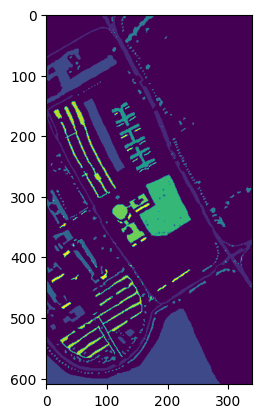

In [ ]:
# Plotting predicted results
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(cnn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
plt.imshow(partial_map)

#full_map = util.plot_full_map(cnn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

#fig, (ax1, ax2) = plt.subplots(1,2,True, True, figsize=(15,7))
#ax1.imshow(partial_map)
#ax1.set_title('Prediction map for labeled data', fontweight="bold", fontsize='14')
#ax2.imshow(full_map)
#ax2.set_title('Prediction map for all data', fontweight="bold", fontsize='14')
#plt.colorbar()
plt.show()

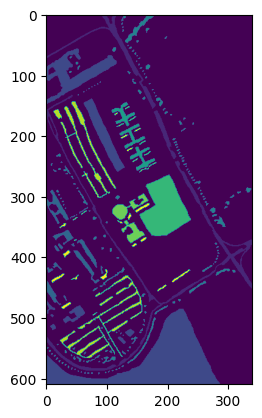

In [ ]:
plt.imshow(gt)